In [36]:
import os, time, random, math
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from pathlib import Path

In [37]:
torch.__version__, torch.cuda.is_available(), torch.cuda.get_device_name(0)

('2.2.1', True, 'NVIDIA GeForce RTX 4060')

In [38]:
PROJECT_ROOT = Path("/workspace")
env_dr = os.getenv("DATA_ROOT", "")
DATA_ROOT = Path(env_dr) if env_dr else PROJECT_ROOT / "data" / "Micro_Organism"
if str(DATA_ROOT).startswith(("C:", "D:", "E:")):
    DATA_ROOT = PROJECT_ROOT/"data"/"Micro_Organism"
NUM_WORKERS = max(2, (os.cpu_count() or 4) // 2)

print("Using DATA_ROOT:", DATA_ROOT)

Using DATA_ROOT: /workspace/data/Micro_Organism


In [39]:
SEED = 42
EPOCHS = int(os.getenv("EPOCHS", 8))
BATCH_SIZE = int(os.getenv("BATCH_SIZE", 32))
IMG_SIZE = int(os.getenv("IMG_SIZE", 224))

In [40]:
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
print("Workers:", NUM_WORKERS)

Device: cuda
Workers: 16


In [41]:
# Transforms (data augmentation in train, clean validation)

IMGNET_MEAN = [0.485, 0.456, 0.406]
IMGNET_STD = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale = (0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMGNET_MEAN, IMGNET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMGNET_MEAN, IMGNET_STD),
])

In [42]:
# Dataset + stratified split (80/20)
# Without transforms to obtain targets

base_ds = ImageFolder(str(DATA_ROOT))
num_classes = len(base_ds.classes)
print("Classes:", base_ds.classes, "| num_classes:", num_classes, "| total images:", len(base_ds))


Classes: ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast'] | num_classes: 8 | total images: 789


In [43]:
targets = np.array(base_ds.targets)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(sss.split(np.zeros_like(targets), targets))

train_ds_full = ImageFolder(DATA_ROOT, transform=train_tfms)
val_ds_full = ImageFolder(DATA_ROOT, transform=val_tfms)

train_ds = Subset(train_ds_full, train_idx)
val_ds = Subset(val_ds_full, val_idx)

pin = (DEVICE == "cuda")
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=pin,
                      persistent_workers=(NUM_WORKERS > 0))
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                    num_workers=NUM_WORKERS, pin_memory=pin,
                    persistent_workers=(NUM_WORKERS > 0))

In [44]:
# Model: ResNet50 (unfreeze layer4 + new head)

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

for p in model.parameters():
    p.requires_grad=False

for p in model.layer4.parameters():
    p.requires_grad=True

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(DEVICE)

In [45]:
# Loss, optimization (differenciated LRs), metrics and AMP

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# 2 groups of parameters: backbone (layer4) and head (fc)
param_groups = [
    {"params": [p for n,p in model.named_parameters() if p.requires_grad and not n.startswith("fc")], "lr": 3e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
]
optimizer = AdamW(param_groups, weight_decay=1e-4)

In [46]:
def make_metrics():
    acc = MulticlassAccuracy(num_classes=num_classes).to(DEVICE)
    prec = MulticlassPrecision(num_classes=num_classes, average="macro").to(DEVICE)
    rec = MulticlassRecall(num_classes=num_classes, average="macro").to(DEVICE)
    return acc, prec, rec

scaler = GradScaler()

In [47]:
#Training / Validation + checkpoint of best model

def run_epoch(dataloader, train=True):
    model.train(mode=train)
    acc_m, prec_m, rec_m = make_metrics()

    total_loss, total_samples = 0.0, 0
    torch.set_grad_enabled(train)
    for xb, yb in dataloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = model(xb)
            loss = criterion(logits, yb)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        bs = xb.size(0)
        total_loss += loss.item() * bs
        total_samples += bs

        preds = logits.argmax(1)
        acc_m.update(preds, yb)
        prec_m.update(preds, yb)
        rec_m.update(preds, yb)

    avg_loss = total_loss / max(1, total_samples)
    return {"loss": avg_loss,
            "acc": acc_m.compute().item(),
            "prec": prec_m.compute().item(),
            "rec": rec_m.compute().item()}

In [48]:
best_val_acc = 0.0
history = {"train": [], "val": []}
os.makedirs("models", exist_ok=True)

for epoch in range (1, EPOCHS + 1):
    t0 = time.time()
    tr = run_epoch(train_dl, train=True)
    vl = run_epoch(val_dl, train=False)

    history["train"].append(tr)
    history["val"].append(vl)

    print(f"[{epoch:02d}/{EPOCHS}] "
        f"train: loss={tr['loss']:.4f} acc={tr['acc']:.4f} prec={tr['prec']:.4f} rec={tr['rec']:.4f} | "
        f"val: loss={vl['loss']:.4f} acc={vl['acc']:.4f} prec={vl['prec']:.4f} rec={vl['rec']:.4f} | "
        f"time={time.time()-t0:.1f}s")

    if vl["acc"] > best_val_acc:
        best_val_acc = vl["acc"]
        torch.save({
            "model": model.state_dict(),
            "classes": ImageFolder(DATA_ROOT).classes,
            "img_size": IMG_SIZE,
            "epoch": epoch,
            "best_val_acc": best_val_acc
        }, "/workspace/models/best_resnet50.pt")
        print(f" New best val_acc = {best_val_acc:.4f} - saved -> models/best_resnet50.pt")

print("Done. Best val_acc:", best_val_acc)
    

[01/8] train: loss=1.6332 acc=0.3764 prec=0.5541 rec=0.3764 | val: loss=1.2766 acc=0.5888 prec=0.6316 rec=0.5888 | time=3.1s
 New best val_acc = 0.5888 - saved -> models/best_resnet50.pt
[02/8] train: loss=0.8287 acc=0.8058 prec=0.8133 rec=0.8058 | val: loss=1.0661 acc=0.6883 prec=0.7267 rec=0.6883 | time=2.0s
 New best val_acc = 0.6883 - saved -> models/best_resnet50.pt
[03/8] train: loss=0.5464 acc=0.8999 prec=0.9072 rec=0.8999 | val: loss=1.0257 acc=0.7047 prec=0.7175 rec=0.7047 | time=2.0s
 New best val_acc = 0.7047 - saved -> models/best_resnet50.pt
[04/8] train: loss=0.4285 acc=0.9463 prec=0.9463 rec=0.9463 | val: loss=1.0529 acc=0.7120 prec=0.7440 rec=0.7120 | time=2.0s
 New best val_acc = 0.7120 - saved -> models/best_resnet50.pt
[05/8] train: loss=0.3730 acc=0.9692 prec=0.9694 rec=0.9692 | val: loss=0.9707 acc=0.7479 prec=0.7719 rec=0.7479 | time=2.0s
 New best val_acc = 0.7479 - saved -> models/best_resnet50.pt
[06/8] train: loss=0.3558 acc=0.9766 prec=0.9788 rec=0.9766 | val

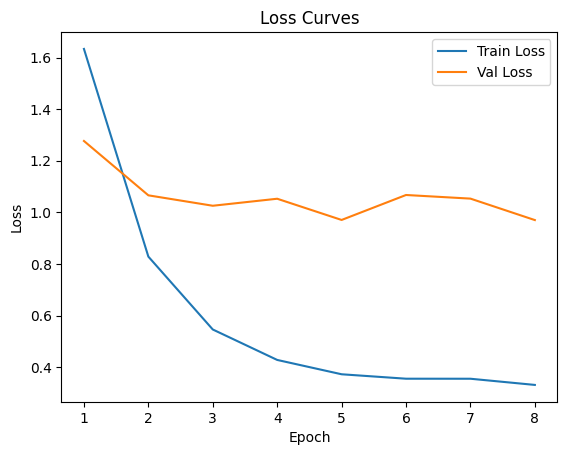

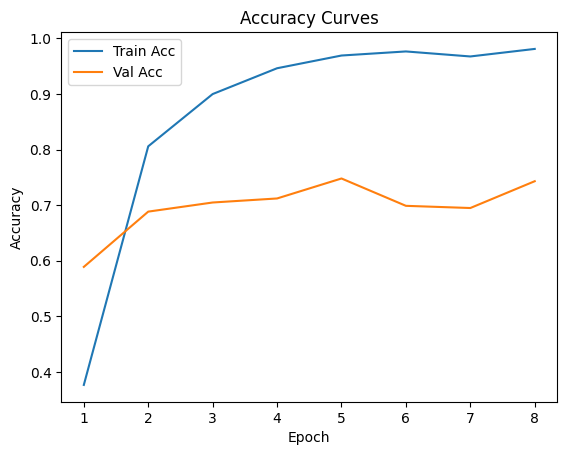

In [49]:
# Loss curves and accuracy

train_loss = [e["loss"] for e in history["train"]]
val_loss = [e["loss"] for e in history["val"]]
train_acc = [e["acc"] for e in history["train"]]
val_acc = [e["acc"] for e in history["val"]]

epochs_axis = np.arange(1, len(train_loss) +1)

plt.figure()
plt.plot(epochs_axis, train_loss, label="Train Loss")
plt.plot(epochs_axis, val_loss, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves"); plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_axis, train_acc, label="Train Acc")
plt.plot(epochs_axis, val_acc, label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curves"); plt.legend()
plt.show()

In [50]:
# Interpretation: it shows a small dataset (fast train but validation don't take the same rythmn)
# I'm going to fine-tune the model because I think with small changes 
# like early stopping, regularization and augmentation, changing IMG_SIZE or other timm
# we should increase the 0.7 we obtained

In [52]:
from PIL import Image

def load_checkpoint(path="/workspace/models/best_resnet50.pt"):
    chk = torch.load(path, map_location=DEVICE)
    m = resnet50()
    m.fc = nn.Linear(m.fc.in_features, len(chk["classes"]))
    m.load_state_dict(chk["model"])
    m.eval().to(DEVICE)
    return m, chk["classes"], chk.get("img_size", 224)

model_inf, classes, img_size = load_checkpoint()

infer_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(IMGNET_MEAN, IMGNET_STD),
])

def predict_image(img_path: str):
    img = Image.open(img_path).convert("RGB")
    x = infer_tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad(), autocast():
        logits = model_inf(x)
        probs = logits.softmax(1)[0]
    i = int(probs.argmax().item())
    return classes[i], float(probs[i].item())

label, score = predict_image("/workspace/data/Micro_Organism/Paramecium/Image_10.jpg")
label, score

('Paramecium', 0.9489885568618774)

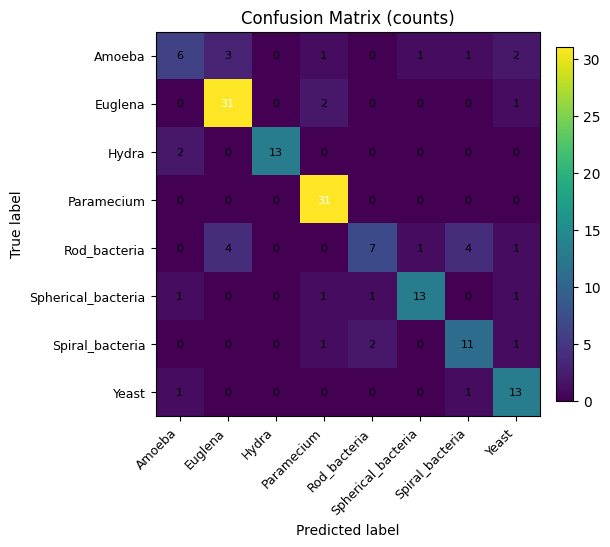

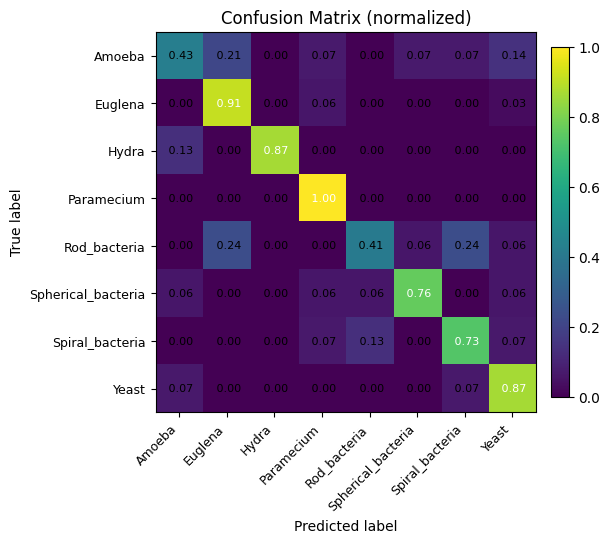


Classification report (per-class metrics):
                    precision    recall  f1-score   support

            Amoeba     0.6000    0.4286    0.5000        14
           Euglena     0.8158    0.9118    0.8611        34
             Hydra     1.0000    0.8667    0.9286        15
        Paramecium     0.8611    1.0000    0.9254        31
      Rod_bacteria     0.7000    0.4118    0.5185        17
Spherical_bacteria     0.8667    0.7647    0.8125        17
   Spiral_bacteria     0.6471    0.7333    0.6875        15
             Yeast     0.6842    0.8667    0.7647        15

          accuracy                         0.7911       158
         macro avg     0.7719    0.7479    0.7498       158
      weighted avg     0.7876    0.7911    0.7804       158



In [53]:
#Confusion matrix per class

model_eval = model_inf.to(DEVICE).eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model_eval(xb)
        preds = logits.argmax(1).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())

y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
cm_norm = cm.astype(np.float64) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

def plot_confusion_matrix(cm_, class_names, normalize=True, title="Confusion Matrix"):
    n = len(class_names)
    side = max(6, 0.6 * n)
    fig, ax = plt.subplots(figsize=(side, side), constrained_layout=True)
    
    M = cm_.astype(float)
    if normalize:
        M = M / np.maximum(M.sum(axis=1, keepdims=True), 1)
        
    im = ax.imshow(M, interpolation="nearest")
    ax.set_title(title + (" (normalized)" if normalize else " (counts)"))
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
   
    tick_marks = np.arange(n)
    ax.set_xticks(tick_marks, class_names, rotation=45, ha="right", fontsize=9)
    ax.set_yticks(tick_marks, class_names, fontsize=9)
    
    thresh = M.max() / 2.0 if M.size else 0.5
    for i in range(n):
        for j in range(n):
            txt = f"{M[i, j]: .2f}" if normalize else f"{int(M[i, j])}"
            ax.text(j, i, txt, ha="center", va="center",
                     color="white" if M[i,j] > thresh else "black", fontsize=8)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

    plt.show()

plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix")
plot_confusion_matrix(cm, classes, normalize=True, title="Confusion Matrix")

print("\nClassification report (per-class metrics):")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

In [54]:
# As per CM, the most difficult classes to differenciate are Rod and Spiral Bacteria with Euglena.
# Amoeba is also difficult to detect.
# Lets see if fine tuning the model we can obtain better results
# May be a bit overfitted.

Showing 6 misclassifications...

[10] real=Spiral_bacteria | pred=Rod_bacteria
/workspace/data/Micro_Organism/Spiral_bacteria/Image_3.jpg


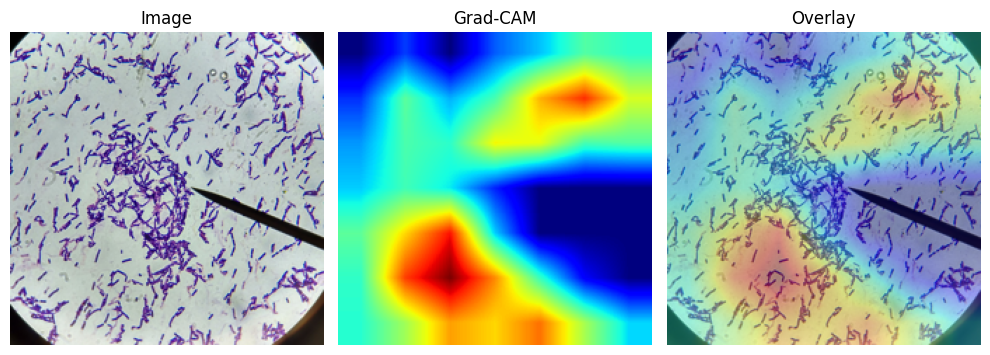

Predicted: [4] Rod_bacteria

[14] real=Euglena | pred=Paramecium
/workspace/data/Micro_Organism/Euglena/Image_165.jpg


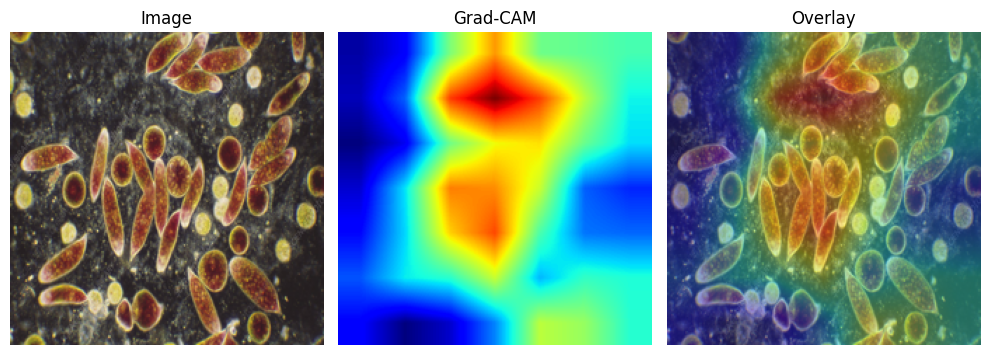

Predicted: [3] Paramecium

[15] real=Amoeba | pred=Euglena
/workspace/data/Micro_Organism/Amoeba/Image_87.jpg


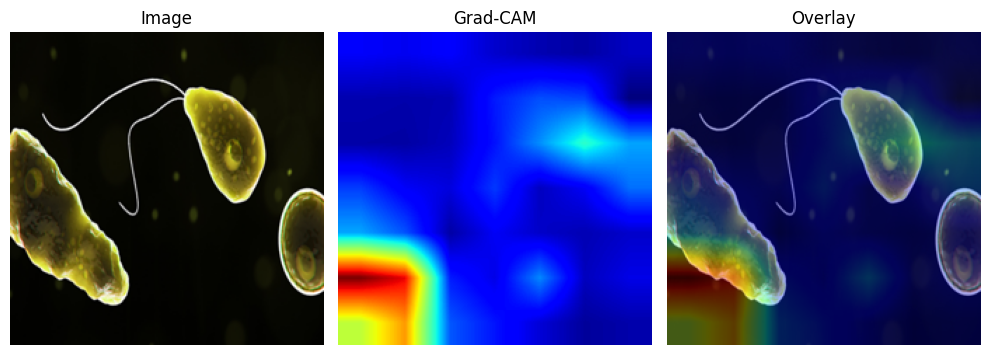

Predicted: [1] Euglena

[18] real=Yeast | pred=Spiral_bacteria
/workspace/data/Micro_Organism/Yeast/Image_46.jpg


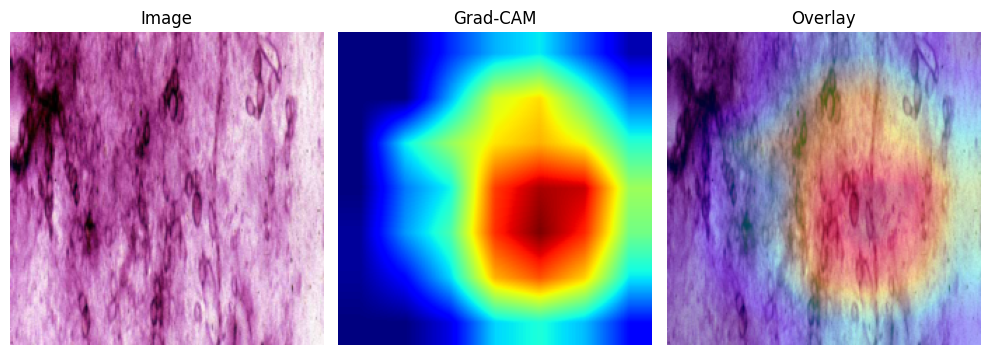

Predicted: [6] Spiral_bacteria

[37] real=Rod_bacteria | pred=Euglena
/workspace/data/Micro_Organism/Rod_bacteria/Image_91.jpg


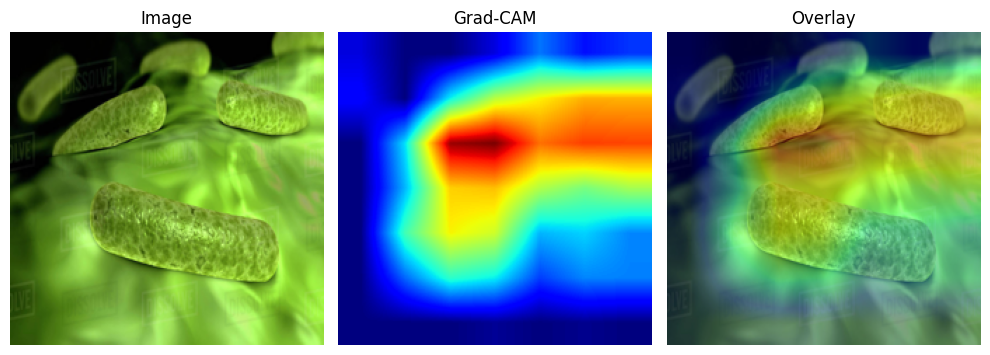

Predicted: [1] Euglena

[38] real=Rod_bacteria | pred=Spherical_bacteria
/workspace/data/Micro_Organism/Rod_bacteria/Image_24.jpg


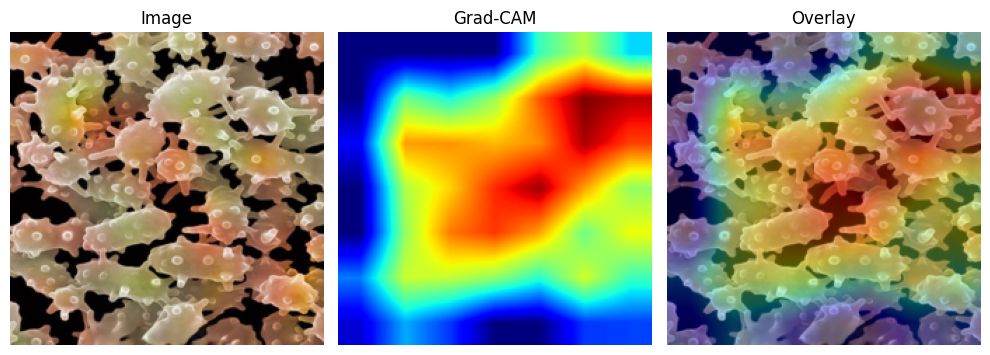

Predicted: [5] Spherical_bacteria


In [55]:
# Saving in output folder Grad-CAMs of TOP-N pairs
import torch.nn.functional as F

def gradcam(model, img_tensor, target_layer, class_idx=None):
    model.eval()
    acts = []

    def fwd_hook(_, __, output):
        acts.append(output)
        output.retain_grad()

    h = target_layer.register_forward_hook(fwd_hook)

    with torch.enable_grad():
        logits = model(img_tensor)
        if class_idx is None:
           class_idx = int(logits.argmax(1).item())
        score = logits[:, class_idx].sum()
        model.zero_grad(set_to_none=True)
        score.backward()
       
       

    A = acts[-1]
    dA = A.grad
    weights = dA.mean(dim=(2, 3), keepdim=True)
    cam = (weights * A).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    cam = F.interpolate(cam, size=img_tensor.shape[-2:], mode="bilinear", align_corners=False)
    cam = cam[0,0].detach().cpu().numpy()

    h.remove()
    return cam, class_idx

def show_gradcam_on_image(img_pil, cam, alpha=0.35):
    img_np = np.array(img_pil.resize((cam.shape[1], cam.shape[0])))

    heatmap = plt.cm.jet(cam)[:, :, :3]
    overlay = (alpha*heatmap +(1-alpha) * (img_np/255.0))
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.axis("off"); plt.title("Image")
    plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.axis("off"); plt.title("Grad-CAM")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.axis("off"); plt.title("Overlay")
    plt.tight_layout()
    plt.show()


def gradcam_for_path(img_path: str, target_class: int | None=None):
    img = Image.open(img_path).convert("RGB")
    x = infer_tfms(img).unsqueeze(0).to(DEVICE)

    target_layer = model_inf.layer4[-1].conv3

    #with torch.no_grad():
    #    _ = model_inf(x)
        
    #for p in model_inf.parameters():
    #    p.requires_grad = False
    #for p in model_inf.layer4[-1].parameters():
    #    p.requires_grad = True
    #for p in getattr(model_inf, "fc").parameters():
    #    p.requires_grad = True

    cam, cls_idx = gradcam(model_inf, x, target_layer, class_idx=target_class)
    pred_idx = cls_idx
    pred_name = classes[pred_idx] if 0 <= pred_idx < len(classes) else str(pred_idx)

    show_gradcam_on_image(
        Image.open(img_path).convert("RGB").resize((x.shape[-1], x.shape[-2])), 
        cam
    )
    print(f"Predicted: [{pred_idx}] {pred_name}")

    
_model_eval = (model_inf if "model_inf" in globals() else model).to(DEVICE).eval()

if "y_true" not in globals() or "y_pred" not in globals():
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(DEVICE, non_blocking=True)
            logits = _model_eval(xb)
            y_true += yb.tolist()
            y_pred += logits.argmax(1).cpu().tolist()
    y_true = np.array(y_true); y_pred = np.array(y_pred)

# Missclassification indexes
mis_idx = np.where(y_true != y_pred)[0]

# Showing Grad-CAM on first N missclassifications
if len(mis_idx) == 0:
    print("There are not missclassifications!")
else:
    N = 6
    print(f"Showing {min(N, len(mis_idx))} misclassifications...")
    for i in mis_idx[:N]:
        img_path = val_ds_full.samples[val_idx[i]][0]
        print(f"\n[{i}] real={classes[y_true[i]]} | pred={classes[y_pred[i]]}\n{img_path}")
        gradcam_for_path(img_path)